In [97]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sorting
import random
from sklearn.preprocessing import MinMaxScaler
import math
from collections import Counter,OrderedDict

## Importing Data 

In [6]:
movie_data=pd.read_csv('/home/acer/Downloads/ml-latest-small/movies.csv')
ratings=pd.read_csv('/home/acer/Downloads/ml-latest-small/ratings.csv')


In [7]:
user_rating=np.zeros((len(np.unique(ratings['userId'])),len(np.unique(ratings['movieId']))))
train=np.zeros(user_rating.shape)
test=np.zeros(user_rating.shape)

# User ratings

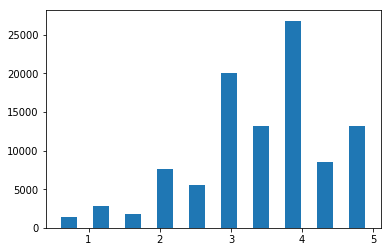

In [72]:
plt.hist(ratings['rating'],rwidth=0.5)
plt.show()

In [79]:
print("Number of Users :",len(np.unique(ratings["userId"])))
print("Number of movies :",len(np.unique(movie_data["movieId"])))

Number of Users : 610
Number of movies : 9742


In [129]:
print("Movies with highest number of user ratings :")
for i in sorted(Counter(ratings["movieId"]).items(), key=lambda x: x[1],reverse=True)[:15]:
    print(movie_data["title"][i[0]])

Movies with highest number of user ratings :
Age of Innocence, The (1993)
I Love Trouble (1994)
Virtuosity (1995)
Cemetery Man (Dellamorte Dellamore) (1994)
Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)
Quiz Show (1994)
Terminal Velocity (1994)
Jupiter's Wife (1994)
Last Dance (1996)
Aristocats, The (1970)
Billy Elliot (2000)
Jumanji (1995)
Picture Perfect (1997)
Georgia (1995)
Autumn in New York (2000)


In [135]:
print("User who gave more ratings (User Number,Number of movies) :")
sorted(Counter(ratings["userId"]).items(), key=lambda x: x[1],reverse=True)[:15]

User who gave more ratings (User Number,Number of movies) :


[(414, 2698),
 (599, 2478),
 (474, 2108),
 (448, 1864),
 (274, 1346),
 (610, 1302),
 (68, 1260),
 (380, 1218),
 (606, 1115),
 (288, 1055),
 (249, 1046),
 (387, 1027),
 (182, 977),
 (307, 975),
 (603, 943)]

# User Rating Matrix

In [8]:
for i in np.unique(ratings['userId']):
    k=ratings[ratings['userId']==i]
    for j in range(len(k)):
        if (k['movieId'].iloc[j]-1<=9742):
            user_rating[i-1,k['movieId'].iloc[j]-1]=k['rating'].iloc[j]

## Test Train split

In [9]:
t=int(np.count_nonzero(user_rating)*80/100)
non_zero=[]
for i in range(user_rating.shape[0]):
    for j in range(user_rating.shape[1]):
        if(user_rating[i,j]!=0):
            non_zero.append([i,j])
k=0
while(k<=t):
    i=random.randint(1,len(non_zero)-1)
    train[non_zero[i][0],non_zero[i][1]]=user_rating[non_zero[i][0],non_zero[i][1]]
    non_zero.remove(non_zero[i])
    k=k+1

In [10]:
train

array([[0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [11]:
for i in non_zero:
    test[i[0],i[1]]=user_rating[i[0],i[1]]

In [12]:
test

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

## Matrix factorization

In [25]:
user=np.random.rand(user_rating.shape[0],5)
movies=np.random.randint(4,size=(user_rating.shape[1],5))
I=np.zeros(user_rating.shape)

In [26]:
for i in range(user_rating.shape[0]):
    for j in range(user_rating.shape[1]):
        if(user_rating[i][j]!=0):
            I[i][j]=1

In [27]:
def gradient(user,movies,result):
    user=user+2*0.000001*(result.dot(movies))
    movies=movies+2*0.000001*(result.T.dot(user))
    return(user,movies)
def prediction(user,movies,user_r,k):
    error=[]
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        user,movie=gradient(user,movies,result)
        error.append(np.sum(np.square(result)))
    return(error,user,movies)

In [28]:
def accuracy (user,movies,data,k):
    error1=prediction(user,movies,data,k)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [267]:
train_ac,train_result=accuracy(user,movies,train,2000)
test_ac,test_result=accuracy(user,movies,test,2000)

In [268]:
test_ac

2.9576379174813496

In [269]:
train_ac

1.6018630520006094

## Regularised Matrix Factorization

In [43]:
beta=0.0001
def prediction2(user,movies,user_r,k):
    error=[]
    for i in range(k):
        result=np.square(np.multiply((user_r-user.dot(movies.T)),I))+beta*((np.sum(np.square(user))+(np.sum(np.square(movies)))))
        user,movies=gradient2(user,movies,result)
        error.append(np.sum(1/(2*user_r.shape[0])*np.square(result)))
    return(error,user,movies)

def gradient2(user,movies,result):
    user=user-0.000000001*(2*(result.dot(movies))+2*beta*(np.sum(user)))
    movies=movies-0.00000001*(2*(result.T.dot(user))+2*beta*np.sum(movies))
    return(user,movies)

In [44]:
def accuracy_regularised(user,movies,data,k):
    error2=prediction2(user,movies,data,k)
    result2=error2[1].dot(error2[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result2[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result2)

In [276]:
train_ac_r,train_result_re=accuracy_regularised(user,movies,train,100)
test_ac_r,test_result_re=accuracy_regularised(user,movies,test,100)

In [277]:
train_ac_r

1.9052207875558322

In [278]:
test_ac_r

1.8984889166291525

## Sliding window 

In [137]:
def gradient_sliding_w(user,movies,result):
    user=user+2*0.0000001*(result.dot(movies))
    movies=movies+2*0.0000001*(result.T.dot(user))
    return(user,movies)
def prediction_sliding_w(user,movies,user_r,k,win_size):
    error=[]
    win=[]
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        user,movie=gradient_sliding_w(user,movies,result)
        e=np.sum(np.square(result))
        error.append(e)
        if(i<win_size):
            win.append(e)
        else:
            mean1=sum(win)/win_size
            del win[0]
            win.append(e)
            mean2=sum(win)/win_size
            if(mean1<mean2):
                break
            else:
                continue
    return(error,user,movies)

In [138]:
def accuracy_sliding_w(user,movies,data,k,win_size):
    error1=prediction_sliding_w(user,movies,data,k,win_size)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [139]:
train_ac_sw,train_result_sw=accuracy_sliding_w(user,movies,train,2000,10)
test_ac_sw,test_result_sw=accuracy_sliding_w(user,movies,test,2000,10)

In [140]:
train_ac_sw

1.6741925079136388

In [141]:
test_ac_sw

2.428895401985971

# Line Search 

In [229]:
def gradient_line_search(user,movies,result,alpha):
    user=user+2*alpha*(result.dot(movies))
    movies=movies+2*alpha*(result.T.dot(user))
    return(user,movies)
def prediction_line_search(user,movies,user_r,k,threshold):
    error=[]
    jold=0
    jnew=0
    alpha=1/9000
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        jnew=np.sum(np.square(result))
        error.append([jnew])
        if(abs(jold-jnew)>threshold):
            alpha=alpha/10
            user,movie=gradient_line_search(user,movies,result,alpha)
        else:
            break
        jold=jnew
    return(error,user,movies)

In [230]:
def accuracy_line_search(user,movies,data,k,win_size):
    error1=prediction_line_search(user,movies,data,k,win_size)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [232]:
train_ac_ls,train_result_ls=accuracy_line_search(user,movies,train,1000,0.001)
test_ac_ls,test_result_ls=accuracy_line_search(user,movies,test,1000,0.001)

In [233]:
train_ac_ls

1.8929676596520677

In [234]:
test_ac_ls

1.8947140478548752

# Recommendation

In [154]:
def find_movie(rating_matrix):
    l=[]
    for i in range(rating_matrix.shape[0]):
        t=[]
        q=sorted(range(len(rating_matrix[0])), key=lambda k: rating_matrix[i][k])
        q.reverse()
        for j in q:
            if(user_rating[i,j]==0):
                t.append(j)
        l.append(t)
    return(l)

In [155]:
def recommendation(user,n,l):
    i=0
    while(n>=0):
        print(l[user][i],"    ",movie_data["title"][l[user][i]])
        i=i+1
        n=n-1

In [156]:
t=prediction(user,movies,user_rating,1000)
predicted_matrix=t[1].dot(t[2].T)

In [165]:
recommendation(1,5,find_movie(predicted_matrix))

9102      Slow Learners (2015)
8446      The Fault in Our Stars (2014)
8418      Mulan II (2004)
4583      Tightrope (1984)
4496      Attack of the Puppet People (1958)
4182      Dogfight (1991)


In [280]:
t_re=prediction2(user,movies,user_rating,100)
predicted_matrix_re=t_re[1].dot(t_re[2].T)

In [281]:
recommendation(1,5,find_movie(predicted_matrix_re))

9102      Slow Learners (2015)
8418      Mulan II (2004)
4182      Dogfight (1991)
1813      Clue (1985)
695      Maltese Falcon, The (1941)
4496      Attack of the Puppet People (1958)


In [161]:
t_sw=prediction_sliding_w(user,movies,user_rating,1000,15)
predicted_matrix_sw=t_sw[1].dot(t_sw[2].T)

In [167]:
recommendation(1,5,find_movie(predicted_matrix_sw))

9102      Slow Learners (2015)
8446      The Fault in Our Stars (2014)
8418      Mulan II (2004)
4583      Tightrope (1984)
4496      Attack of the Puppet People (1958)
4182      Dogfight (1991)


In [163]:
t_ls=prediction_line_search(user,movies,user_rating,1000,0.00001)
predicted_matrix_ls=t_ls[1].dot(t_ls[2].T)

In [168]:
recommendation(1,5,find_movie(predicted_matrix_ls))

9102      Slow Learners (2015)
8446      The Fault in Our Stars (2014)
8418      Mulan II (2004)
4583      Tightrope (1984)
4496      Attack of the Puppet People (1958)
4182      Dogfight (1991)


In [255]:
def show(mat):
    rate=[]
    for i in range(user_rating.shape[0]):
        for j in range(user_rating.shape[1]):
            if(user_rating[i][j]!=0):
                rate.append(mat[i][j])
    m=min(rate)
    n=max(rate)
    plt.hist([(r-m)/(n-m) for r in rate],rwidth=0.5)
    plt.show()

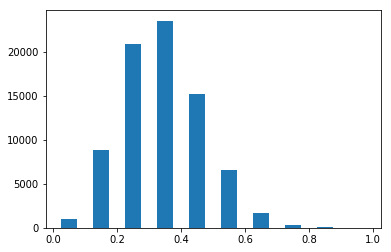

In [256]:
print("Using Matrix Factorisation :")
show(predicted_matrix)


Using Regularisation :


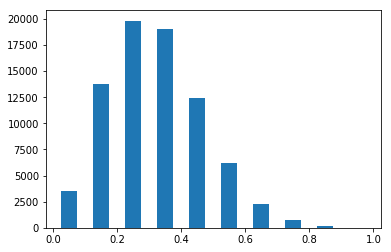

In [282]:
print("Using Regularisation :")
show(predicted_matrix_re)

Using Sliding Window :


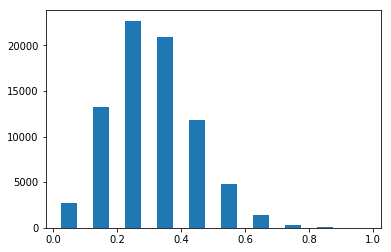

In [261]:
print("Using Sliding Window :")
show(predicted_matrix_sw)

Using line search :


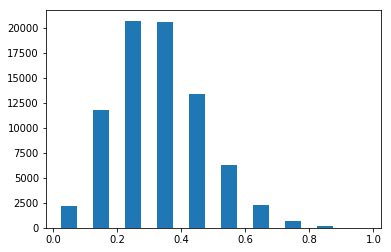

In [262]:
print("Using line search :")
show(predicted_matrix_ls)